In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib.patches import Patch
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.svm import l1_min_c

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC



In [32]:

football_data = pd.read_excel("TOTAL_DATA_FINAL.xlsx", index_col='Squad').drop(columns = ['xGD', 'KP'])

#football_data = football_data.loc[ (football_data.league == 'serie_a') | (football_data.league == 'la_liga') | (football_data.league == 'premier')].drop(columns = ['league'])

football_data = football_data.drop(columns = ['league'])

cutoff = int(len(football_data)*.5)

cutoff = len(football_data) - 100

football_train = football_data[:cutoff]
football_test = football_data[cutoff:]

top_4_or_not = np.select([football_data["Rk"].values <= 4,
                          (football_data["Rk"].values > 4) & (football_data["Rk"].values <= 14),
                          (football_data["Rk"].values > 14)], [1,2,3])

'''
top_4_or_not = np.select([football_data["Rk"].values == 1, 
                          (football_data["Rk"].values > 1) & (football_data["Rk"].values <= 4), 
                          (football_data["Rk"].values > 4) & (football_data["Rk"].values <= 12),
                          #(football_data["Rk"].values > 7) & (football_data["Rk"].values <= 17),
                          football_data["Rk"].values > 12], [1,2,3,4])
'''

# top_4_or_not[:cutoff]
# football_train["Rk"].values
X_train = football_train[[i for i in football_test.columns if i != "Rk" and i != 'league']]
Y_train = top_4_or_not[:cutoff]

X_test = football_test[[i for i in football_test.columns if i != "Rk" and i != 'league']]
Y_test = top_4_or_not[cutoff:]

forest = RandomForestClassifier(n_estimators = 100).fit(X_train, Y_train)

/var/folders/5c/pr4qxx_n549__j7rk3s5rgkc0000gp/T/ipykernel_13250/2161600255.py:36: RuntimeWarning: invalid value encountered in log
  np.log(-0.9799529966981132)


nan

In [34]:


min_cs = l1_min_c(X_train, Y_train, loss="log") * np.logspace(0, 7, 23)

clf = SVC(C=0.1047241883966603, gamma='auto', kernel="linear")
clf.fit(X_train, Y_train)

preds = clf.predict(X_test)
confusion = confusion_matrix(Y_test, preds)

Text(0.5, 0, 'Log of Regularization Parameter C')

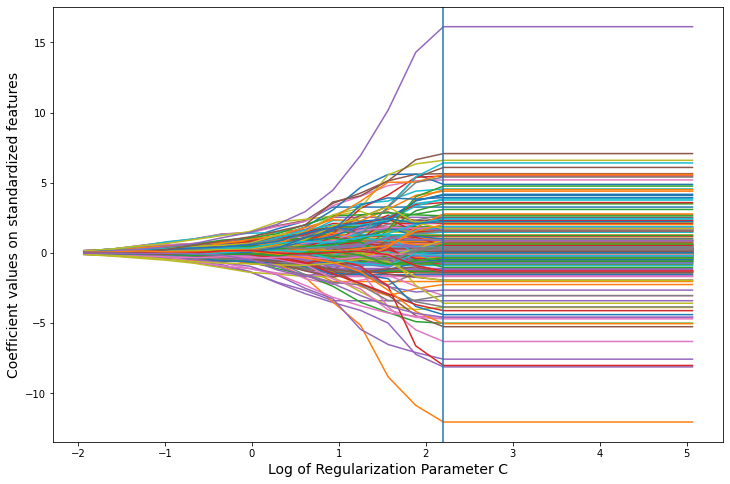

In [40]:


coefs = []
fits = []
regular_fits = []


for mc in min_cs:
    
    new_clf = SVC(C=mc, gamma='auto', kernel = "linear")
    
    new_clf.fit(X_train, Y_train)
    
    fits.append(new_clf.fit(X_train, Y_train))
    
    #regular_fits.append(LogisticRegression(C=mc).fit(X_test, Y_test))

    coefs.append(new_clf.coef_.ravel().copy())

sum_of_l1_coefs = np.array([np.sum(i) for i in coefs])
x_val_of_max = np.where(sum_of_l1_coefs == max(sum_of_l1_coefs))[0][0]

x = np.log10(min_cs)

train_accuracy = [f.score(X_train, Y_train) for f in fits]
test_accuracy = [f.score(X_test, Y_test) for f in fits]

plt.figure(figsize = (12,8))
plt.plot(x, coefs)
plt.axvline(x[x_val_of_max])
plt.ylabel("Coefficient values on standardized features", size = 14)
plt.xlabel("Log of Regularization Parameter C", size = 14)


In [33]:

optimum_regularization_parameter = min_cs[np.where(test_accuracy == max(test_accuracy))[0][0]]

optimum_regularization_parameter


0.1047241883966603

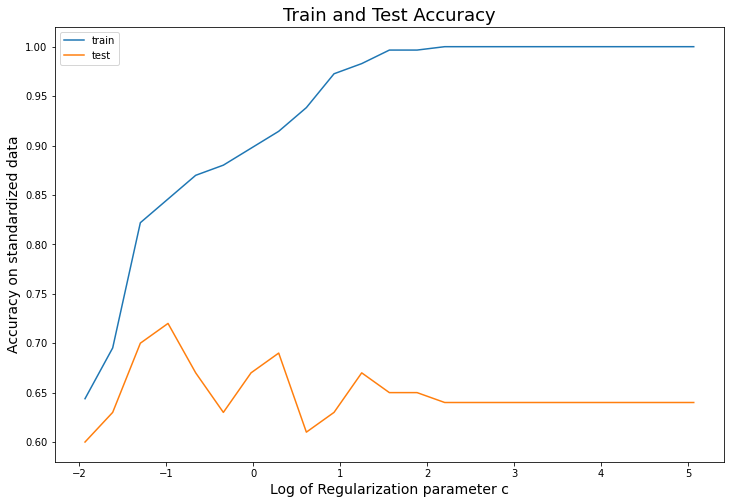

In [39]:

plt.figure(figsize = (12,8))
plt.plot(x, train_accuracy, label="train")
plt.plot(x, test_accuracy, label="test")
plt.title("Train and Test Accuracy", size = 18)
plt.xlabel("Log of Regularization parameter c", size = 14)
plt.ylabel("Accuracy on standardized data", size = 14)
plt.legend(['train', 'test'])


0.72

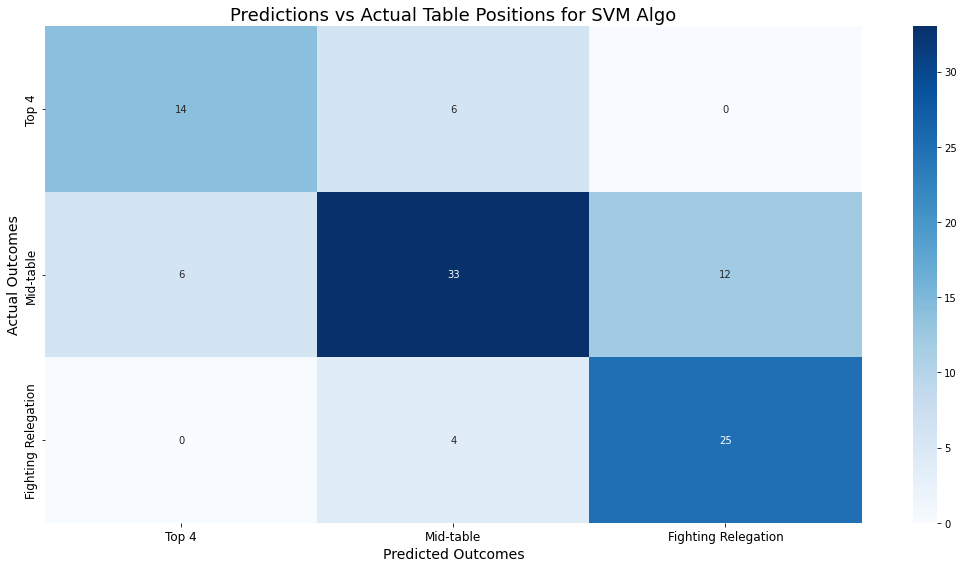

In [35]:

plt.figure(figsize=(15,8))
fig = sns.heatmap(confusion, annot=True, cmap='Blues')
fig.set_xticklabels(['Top 4', 'Mid-table', 'Fighting Relegation'], size = 12)
fig.set_yticklabels(['Top 4', 'Mid-table', 'Fighting Relegation'], size = 12)
#fig.set_xticklabels(['League Winner','Top 4', 'Mid-table', 'Relegated'])
#fig.set_yticklabels(['League Winner','Top 4', 'Mid-table', 'Relegated'])
fig.set_title("Predictions vs Actual Table Positions for SVM Algo", size = 18)
fig.set_xlabel("Predicted Outcomes", size = 14)
fig.set_ylabel("Actual Outcomes", size = 14)
plt.tight_layout()

accuracy_score(Y_test, preds)